In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import scipy.stats
from tqdm import tqdm

/Users/frederikrogge/miniforge3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SpaceNet(torch.nn.Module):
    def __init__(self, nr):
        super(SpaceNet, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.spatial_representation = torch.nn.Sequential(
            torch.nn.Linear(2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, nr),
            torch.nn.ReLU()
        )

    def forward(self, r):
        p = self.spatial_representation(r) # ns, nr
        corr = p@p.T # correlation matrix
        return p, corr

In [3]:
def train_step(model, r, scale = 0.1):
    p, corr = model(r)
    d = torch.sum((r[:,None] - r[None])**2, dim = -1)
    correlation_loss = (corr - torch.exp(-0.5/scale**2*d))**2
    return torch.mean(correlation_loss)

In [4]:
train_steps = 5000

nr = 100 # no. of spatial representations
bs = 512 # batch size

model = SpaceNet(nr)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
  optimizer.zero_grad()

  r = np.random.uniform(-1, 1, (bs, 2)).astype("float32")
  loss = train_step(model, torch.tensor(r))

  loss.backward()
  optimizer.step()

  if i % 10 == 0:
      loss = loss.item()
      loss_history.append(loss)
      progress.set_description(f"loss: {loss:>7f}")

loss: 0.003871: 100%|██████████| 5000/5000 [00:33<00:00, 148.22it/s]


Text(0, 0.5, 'Train Loss')

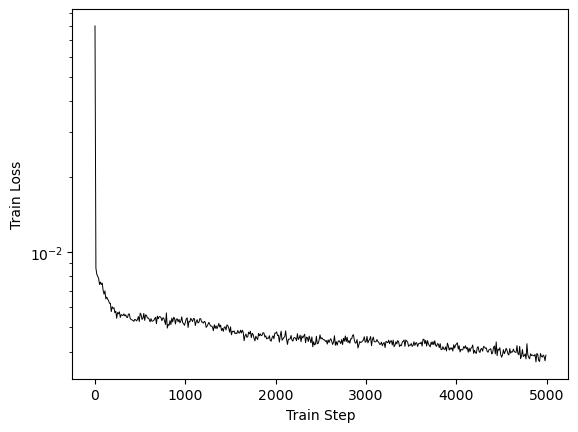

In [5]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [6]:
# evaluate on 2x2 grid
n = 64
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = np.stack([xx.ravel(), yy.ravel()], axis = -1).astype("float32")
# inference
p, pcorr = model(torch.tensor(u))
p = p.detach().numpy()
pcorr = pcorr.detach().numpy()

In [12]:
p.shape

(4096, 100)

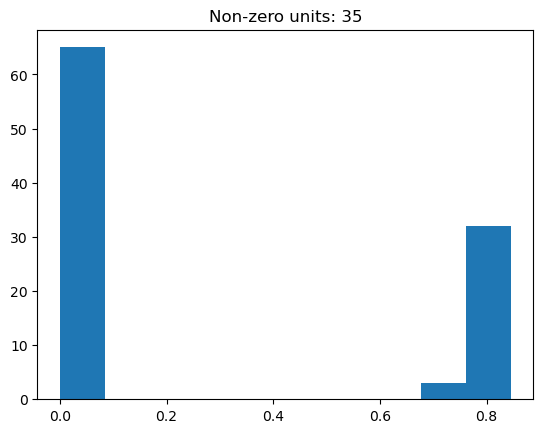

In [13]:
# select units nonzero activity
max_ind = np.argmax(p, axis = 0) 
max_loc = u[max_ind]
mask = np.array([p[ind, i] > 0 for i, ind in enumerate(max_ind)])
nonzero_max_loc = max_loc[mask]

p[:,mask].shape
plt.hist(np.amax(p, axis = 0))
plt.title(f"Non-zero units: {mask.sum()}")
plt.show()

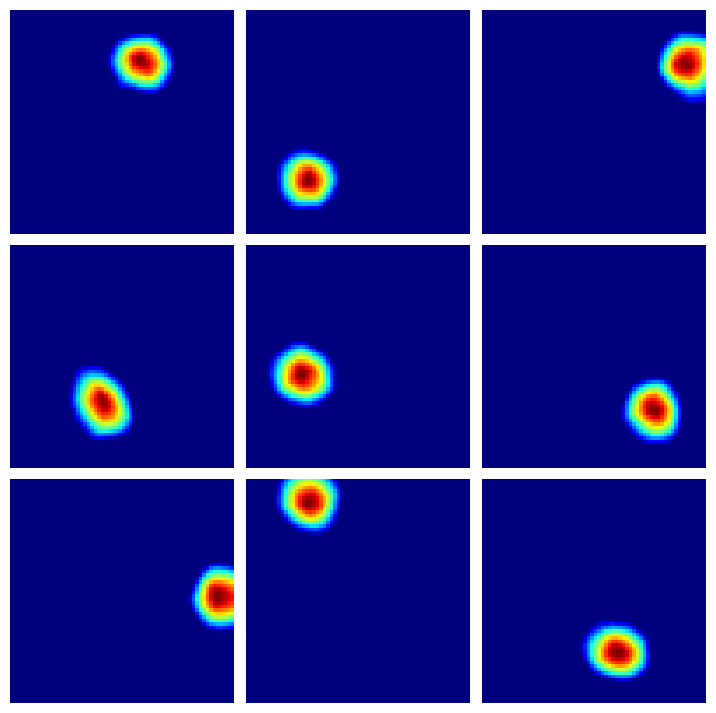

In [16]:
fig, ax = plt.subplots(3, 3, figsize = (9,9))

for i, representation in enumerate((p[:,mask].T)[:9]):
  row = i // 3
  col = i % 3
  ax[row, col].axis("off")
  ax[row, col].imshow(representation.reshape(n, n), cmap = "jet")

plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
#plt.savefig("Cells.png")

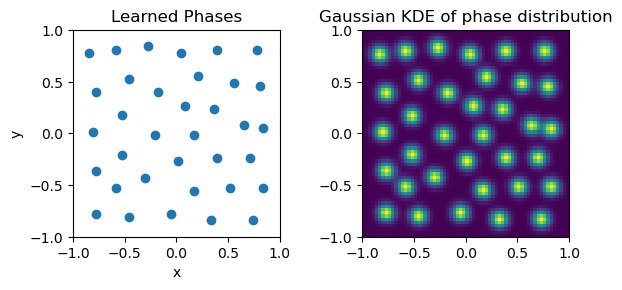

In [17]:
lims = [-1, 1, -1, 1]
# KDE of phase distribution after training
kde = scipy.stats.gaussian_kde(np.array(nonzero_max_loc).T, 0.1)
eval_kde = kde(np.array(u).T)
fig, ax = plt.subplots(1, 2, sharex = True)
ax[0].plot(nonzero_max_loc[:,0], nonzero_max_loc[:,1], "o")
ax[1].imshow(eval_kde.reshape(n, n), origin = "lower", extent = lims)

for i in range(2):
  ax[i].axis(lims)
  ax[i].set_aspect("equal")

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Learned Phases")
ax[1].set_title("Gaussian KDE of phase distribution")
plt.subplots_adjust(wspace = 0.4)
#plt.savefig("Phases.png")